<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 10</strong></h2>

<h3><strong>Noise & Error Mitigation</strong></h3>

</div>

*In this session, we will learn about common noise/error sources in quantum computing and some techniques for error mitigation!*

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
1. Learn about single-qubit errors.
2. Explore decoherence mechanisms.
3. Learn error mitigation techniques: dynamical decoupling and zero-noise extrapolation

<div/>

## Setup & Imports

In [62]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from quantumrings.toolkit.qiskit import QrBackendV2, QrEstimatorV1
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import RZGate, RXGate
!pip -q install qiskit_aer
from qiskit_aer import AerSimulator
from QuantumRingsLib import QuantumRingsProvider
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    mixed_unitary_error,
    coherent_unitary_error
)
provider   = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits=2)


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Helper Functions

Circuit with decoherence: run a quantum circuit with T1 and T2 decay applied for t_delay during every identity gate. (The error is applied to all qubits in the circuit). You can also optionally add other errors which will also be applied during identity gates.

In [63]:
def circuit_with_decoherence(quantum_circuit, T1, T2, t_delay, shots=1000, extra_errors=[]):
    
    error = thermal_relaxation_error(T1, T2, t_delay)

    # add in additional errors
    for err in extra_errors:
        error = error.compose(err)
     
    # Add errors to noise model
    noise_thermal = NoiseModel()
    noise_thermal.add_all_qubit_quantum_error(error, "id")

    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=noise_thermal)
     
    # Transpile circuit for noisy basis gates
    # Optimization level = 0 preserves identity gates
    passmanager = generate_preset_pass_manager(
        optimization_level=0, backend=sim_noise
    )
    qc_noisy = passmanager.run(quantum_circuit)
     
    # Run and get counts
    result = sim_noise.run(qc_noisy, shots=shots).result()
    counts = result.get_counts()

    # add in zero data, to make data analysis easier
    bitstrings = [''.join(str(bit) for bit in bits) for bits in itertools.product([0,1], repeat=qc.num_qubits)]

    for string in bitstrings:
        if string not in counts.keys():
            counts[string] = 0

    return counts

GHZ: prepare the GHZ state with num_qubit qubits

In [64]:
def ghz(num_qubits):
    qc = QuantumCircuit(num_qubits)

    qc.h(0)
    for qubit in range(num_qubits - 1):
        qc.cx(qubit, qubit + 1)

    return qc

Parity: returns the average parity given a counts dictionary. The parity of a bitstring is 1 if the number of 1s in the bitstring is even, and -1 if the number of 1s in the bitstring is odd.

In [65]:
def parity(counts):
    z  = 0
    tot = sum(counts.values())
    for bitstr, c in counts.items():
        parity_bit = (-1)**(bitstr.count("1"))
        z += parity_bit * c
    return z / tot

Bell state prep: prepare the bell state $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$

In [66]:
def bell_state_prep():
    qc = QuantumCircuit(2, name='QSS10.1.bell_state')
    qc.h(0)
    qc.cx(0,1)

    return qc

# 1. Single-Qubit Errors

<div style="background-color:rgba(243, 248, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(101, 174, 247, 1.0); color: #000000;">

The most basic form of error is a single-qubit error, incurred during a gate or measurement. We usually talk about bit flip and phase flip errors, especially in the context of quantum error correction, which we will cover in Episode 13.

A bit flip error acts as:

$$ \alpha|0\rangle + \beta |1\rangle \rightarrow \alpha|1\rangle + \beta |0\rangle $$

A phase flip error acts as:

$$ \alpha|0\rangle + \beta |1\rangle \rightarrow \alpha|0\rangle - \beta |1\rangle $$

</div>

### Bit Flip Error

In [67]:
qc = bell_state_prep()
qc.measure_all()

display(qc.draw())

p = 0.05
bit_flip_error = pauli_error([('X',p),('I',1-p)])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(bit_flip_error,["h"])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)
     
# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(backend=sim_noise)
qc_noisy = passmanager.run(qc)

# Run and get counts
result = sim_noise.run(qc_noisy, shots=1000).result()
counts = result.get_counts()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

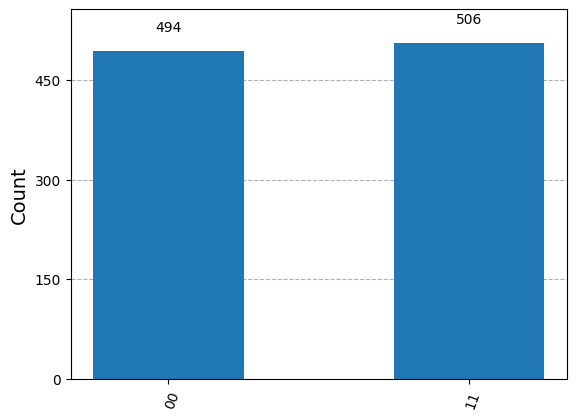

In [68]:
plot_histogram(counts)

Why didn't the bit flip error impact our end result?

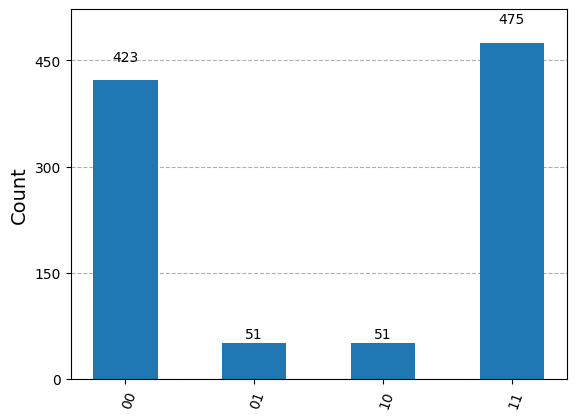

In [69]:
qc = bell_state_prep()
qc.measure_all()

p = 0.1  # probability of bit-flip
bit_flip_error = pauli_error([('IX', p), ('II', 1-p)])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(bit_flip_error, ['cx'])

sim_noise = AerSimulator(noise_model=noise_model)
passmanager = generate_preset_pass_manager(backend=sim_noise)
qc_noisy = passmanager.run(qc)

# Run and get counts
result = sim_noise.run(qc_noisy, shots=1000).result()
counts = result.get_counts()

plot_histogram(counts)

### Phase Flip Error

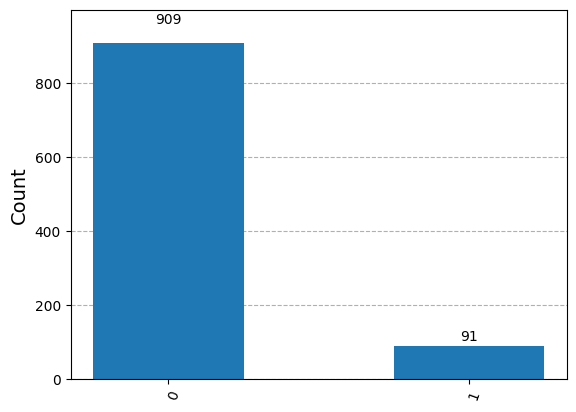

In [70]:
qc = QuantumCircuit(1, name='QSS10.2.phase_flip')
qc.h(0)
qc.id(0)
qc.h(0)
qc.measure_all()

p = 0.1  # probability of bit-flip
phase_flip_error = pauli_error([('Z', p), ('I', 1-p)])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(phase_flip_error, ['id'])

sim_noise = AerSimulator(noise_model=noise_model)
passmanager = generate_preset_pass_manager(optimization_level=0, backend=sim_noise)
qc_noisy = passmanager.run(qc)

# Run and get counts
result = sim_noise.run(qc_noisy, shots=1000).result()
counts = result.get_counts()

plot_histogram(counts)

### Readout Error

In [71]:
num_qubits = 4
qc = QuantumCircuit(num_qubits, name='QSS10.3.readout_error')

qc.compose(ghz(num_qubits), inplace=True)
qc.measure_all()
qc.draw()

┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3

In [72]:
# Measurement misassignment probabilities
p0given1 = 0.1
p1given0 = 0.05
 
error = ReadoutError([[1-p1given0, p1given0],[p0given1,1-p0given1]])

# Create an empty noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_readout_error(error)

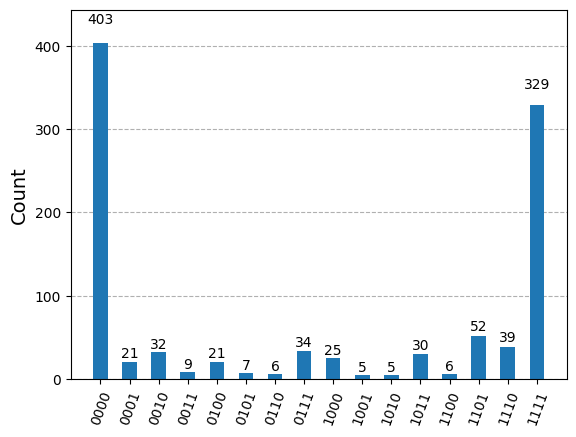

In [73]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)
 
# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(
    optimization_level=0, backend=sim_noise
)
qc_noisy = passmanager.run(qc)
 
# Run and get counts
result = sim_noise.run(qc_noisy).result()
counts = result.get_counts(0)
 
# Plot noisy output
plot_histogram(counts)

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Suppose you are a quantum scientist and you are trying to characterize the readout noise for a qubit. What would your approach be to determine the underlying noise model? Try coding it up.

<div/>

# 2. Decoherence

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

Qubits decohere primarily through coupling to the environment. This is why atoms have longer coherence times than superconducting qubits -- because atoms are more protected from the environment than superconducting qubits. One of the main decay mechanisms is amplitude damping, which is the tendency for the excited state $|1\rangle$ to decay to the ground state $|0\rangle$, i.e. the qubit loses energy to the environment. The other is dephasing, where we lose the phase information of the qubit.

</div>

## Amplitude Damping

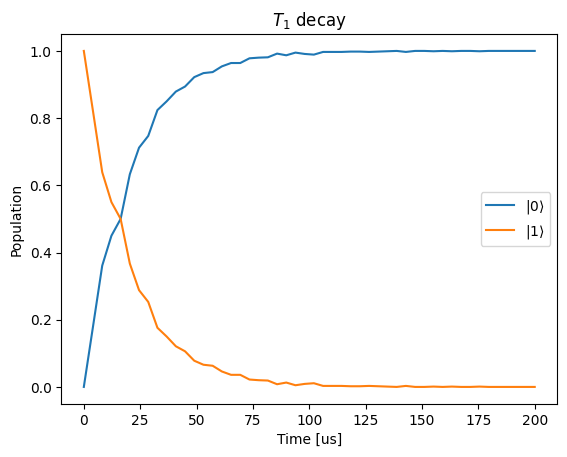

In [74]:
qc = QuantumCircuit(1, name='QSS10.4.t1')
qc.x(0)
qc.id(0)
qc.measure_all()

T1 = 20e3#(ns)
T2 = 30e3#(ns)

t_delays = np.linspace(0e3,200e3,50)
shots = 1000
population_0 = []
population_1 = []
for t_delay in t_delays:
    counts = circuit_with_decoherence(qc, T1, T2, t_delay, shots=shots)
    population_0.append(counts['0']/shots)
    population_1.append(counts['1']/shots)

plt.plot(t_delays*1e-3, population_0, label=r"$|0\rangle$")
plt.plot(t_delays*1e-3, population_1, label=r"$|1\rangle$")
plt.xlabel('Time [us]')
plt.ylabel('Population')
plt.title('$T_1$ decay')
plt.legend()
plt.show()

## Dephasing

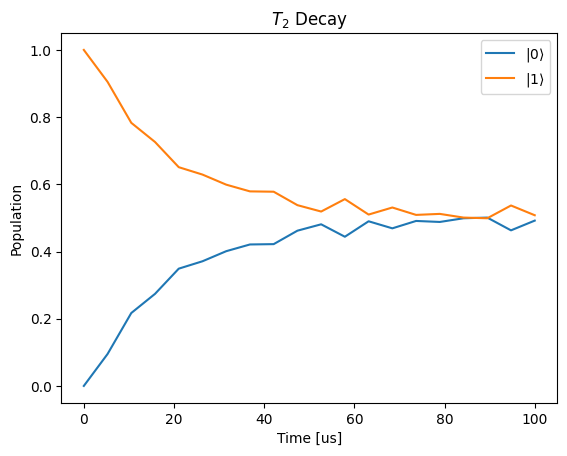

In [75]:
qc = QuantumCircuit(1, name='QSS10.5.t2')
qc.rx(np.pi/2,0)
qc.id(0)
qc.rx(np.pi/2,0)
qc.measure_all()

T1 = 10000e3#(ns) make this really long!
T2 = 20e3#(ns)

t_delays = np.linspace(0e3,100e3,20)
shots = 1000
population_0 = []
population_1 = []
for t_delay in t_delays:
    counts = circuit_with_decoherence(qc, T1, T2, t_delay, shots=shots)
    population_0.append(counts['0']/shots)
    population_1.append(counts['1']/shots)

plt.plot(t_delays*1e-3, population_0, label=r"$|0\rangle$")
plt.plot(t_delays*1e-3, population_1, label=r"$|1\rangle$")
plt.xlabel('Time [us]')
plt.ylabel('Population')
plt.title('$T_2$ Decay')
plt.legend()
plt.show()

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Consider the following questions:

**A)** If you try to make $T_2 > 2T_1$, qiskit will throw an error, because it is physically impossible for $T_2$ to be greater than $2T_1$. Can you give an argument for why this makes sense?

**B)** One thing we care a lot about in quantum computing is ``quantum volume''. We can only fit in so many gates before our qubits lose coherence and our computation is useless. For a superconducting qubit, coherence times are on the order of $10 - 100~\mu s$, and single qubit gates are around $50-100 ~ns$. How many gates (order of magnitude) can you apply before $T_1$?

<div/>

# 3. Error Mitigation

<div style="background-color:rgba(255, 245, 253, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 235, 1.0); color: #000000;">

One way to deal with the noise and errors in quantum circuits is error mitigation. Two common techniques are dynamical decoupling and zero-noise extrapolation. With dynamical decoupling, we can cancel out coherent phase errors. With zero-noise extrapolation, we can estimate the value of an observable in the absence of noise by scaling up the noise.

<div/>

## Dynamical Decoupling

We can think of dephasing as the vector representing the qubit state ``fanning out'' into many vectors on the Bloch sphere. The way in which dephasing occurs is usually not completely random, but instead has to do with how the qubit interacts with the environment. This means that if we flipped the Bloch sphere upside down, the vectors which were originally moving towards the right would now be moving towards the left at the same velocity. At some point in time, all the vectors would recombine at the starting point. We call this an echo.

A good animation can be found here: https://en.wikipedia.org/wiki/Spin_echo

The idea behind dynamical decoupling is to use a pi-pulse in the middle of the sequence such that the dephasing in the first half of the sequence and the second half of the sequence cancel -- there is an echo at the end of the sequence. The overall dephasing noise is reduced. Dynamical decoupling reduces error, but it does not stop them from occuring.

In [76]:
def spin_echo(use_echo=True):
    # Spin echo circuit
    qc = QuantumCircuit(1, name='QSS10.6.spin_echo')
    qc.rx(np.pi/2,0)
    qc.id(0)
    if use_echo:
        qc.x(0)
        qc.rx(-np.pi/2,0)
    else:
        qc.id(0)
        qc.rx(np.pi/2,0)
    qc.measure_all()

    return qc

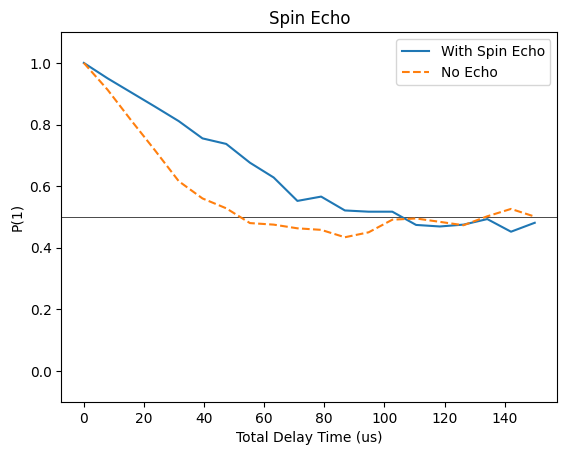

In [77]:
T1 = 1e10
T2 = 50e3
shots = 1000

# Plot comparison: with and without echo
t_delays = np.linspace(0, 150e3, 20)
p1_echo = []
p1_no_echo = []

for t_delay in t_delays:

    # Create coherent phase noise as small RZ rotations with equal probability
    thetas = np.linspace(0,1e-5 * np.pi, 10) * t_delay
    p = 1.0 / len(thetas)
    rz_errors = [(RZGate(theta), p) for theta in thetas]
    
    error = mixed_unitary_error(rz_errors)
    
    counts_echo = circuit_with_decoherence(spin_echo(use_echo=True), T1, T2, t_delay/2, shots=shots, extra_errors=[error])
    counts_noecho = circuit_with_decoherence(spin_echo(use_echo=False), T1, T2, t_delay/2, shots=shots, extra_errors=[error])
    p1_echo.append(counts_echo['1'] / shots)
    p1_no_echo.append(counts_noecho['1'] / shots)

plt.plot(t_delays*1e-3, p1_echo, label="With Spin Echo")
plt.plot(t_delays*1e-3, p1_no_echo, label="No Echo", linestyle='--')
plt.axhline(0.5, color='k', lw=0.5, zorder=0)
plt.xlabel("Total Delay Time (us)")
plt.ylabel("P(1)")
plt.title("Spin Echo")
plt.legend()
plt.ylim(-0.1,1.1)
plt.show()

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

We determine $T_1$ and $T_2$ by fitting the data with an exponential decay function $f(t)=e^{-t/T_1}$ and $f(t)=e^{-t/T_2}$ respectively. For the case of the spin-echo, try fitting both the curves with an exponential. Does the one with spin-echo or without spin-echo better match the $T_2$ we provided the noise model?

<div/>

# Zero-Noise Extrapolation

Suppose we have a circuit with noisy gates described by unitary $U$. In a perfect world, applying $U^\dagger U$ should be the identity, but in practice, the overall gates will cancel and the noise will be doubled because each gate is performed twice. By ``folding'' in more copies of $U$, we amplify the noise even more. Then, we can fit the results vs. the number of folds and extrapolate to zero noise -- zero-noise extrapolation.

In [78]:
# Create noise model
noise_model = NoiseModel()

# 1-qubit coherent error: overrotation of Rx
epsilon = np.deg2rad(2)  # 2 degree overrotation
coherent_err = coherent_unitary_error(RXGate(epsilon))

# 1-qubit depolarizing noise
depol_1q = depolarizing_error(0.02, 1)

# 2-qubit depolarizing noise
depol_2q = depolarizing_error(0.02, 2)

# Add to noise model
noise_model.add_all_qubit_quantum_error(coherent_err.compose(depol_1q), ['h', 'x'])
noise_model.add_all_qubit_quantum_error(depol_2q, ['cx'])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)
 
# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(
    optimization_level=0, backend=sim_noise
)

In [79]:
scale_factors = [1,3,5,7]
parities = []

for scale in scale_factors:
    
    num_qubits = 4
    qc = QuantumCircuit(num_qubits, name='QSS10.7.zne')

    qc.compose(ghz(num_qubits), inplace=True)

    num_folds = int((scale-1)/2)
    for _ in range(num_folds):
        qc.compose(ghz(num_qubits).inverse(),inplace=True)
        qc.compose(ghz(num_qubits),inplace=True)
        
    qc.measure_all()

    qc_noise = passmanager.run(qc)
     
    # Run and get counts
    result = sim_noise.run(qc_noise, shots=1000).result()
    counts = result.get_counts(0)

    parities.append(parity(counts))

Parity after ZNE extrapolation: 1.005 +- 0.028


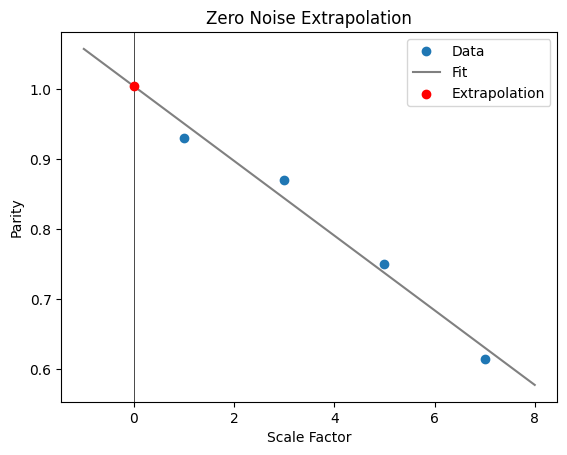

In [80]:
# Linear fit and extrapolation
coeff, cov = np.polyfit(scale_factors, parities, 1, cov=True)
uncertainties = np.sqrt(np.diag(cov))
best_fit = np.poly1d(coeff)
print(f"Parity after ZNE extrapolation: {coeff[1]:.3f} +- {uncertainties[1]:.3f}")

scales = np.linspace(-1,scale_factors[-1]+1)
plt.plot(scale_factors, parities, 'o', ls="", label='Data')
plt.plot(scales, best_fit(scales), label="Fit", color='grey', zorder=0)
plt.axvline(0, color='k', lw=0.5, zorder=0)
plt.scatter(0, coeff[1], label="Extrapolation", color='red')
plt.xlabel("Scale Factor")
plt.ylabel("Parity")
plt.title("Zero Noise Extrapolation")
plt.legend()
plt.show()

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Implement the ZNE technique for another observable. Here are some examples, or you can choose your own:

* The GHZ state parity with the number of qubits something other than 4. For which values does the ZNE method help?
* A single qubit circuit with a rotation $Rz(\theta)$ which has a small unwanted $Rx(\phi)$ rotation. The final measurement result should be 1 with probability $sin^2(\theta/2)$, so in other words, the average measured value should be $sin^2(\theta/2)$. Use ZNE to extrapolate for this expectation value.

<div/>